--2025-08-21 19:36:55--  https://drive.google.com/uc?export=download&id=1IAfLZwu6rizyWKgBTogwSmmVYU6VbjVs
Resolving drive.google.com (drive.google.com)... 173.194.217.102, 173.194.217.101, 173.194.217.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IAfLZwu6rizyWKgBTogwSmmVYU6VbjVs&export=download [following]
--2025-08-21 19:36:55--  https://drive.usercontent.google.com/download?id=1IAfLZwu6rizyWKgBTogwSmmVYU6VbjVs&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 192.178.219.132, 2607:f8b0:400c:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|192.178.219.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-08-21 19:36:55 ERROR 404: Not Found.

--2025-08-21 19:36:55--  https://drive.google.com/uc?export=download&id=1PgQC0tO8XN-wqk

/tmp/ipython-input-4255701019.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2023-01-01', '2023-12-31', freq='H')


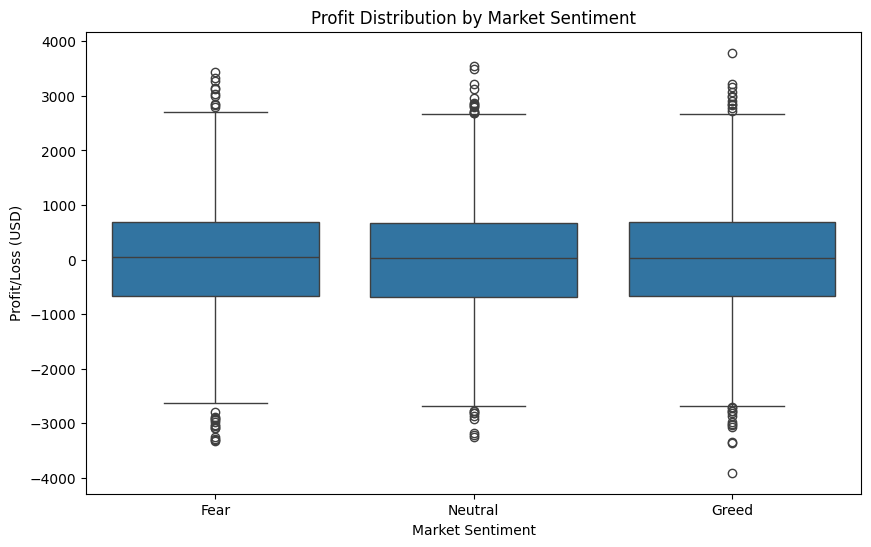

/tmp/ipython-input-4255701019.py:171: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leverage_profit = merged_df.groupby(['leverage_bucket', 'Classification'])['is_profitable'].mean().unstack()


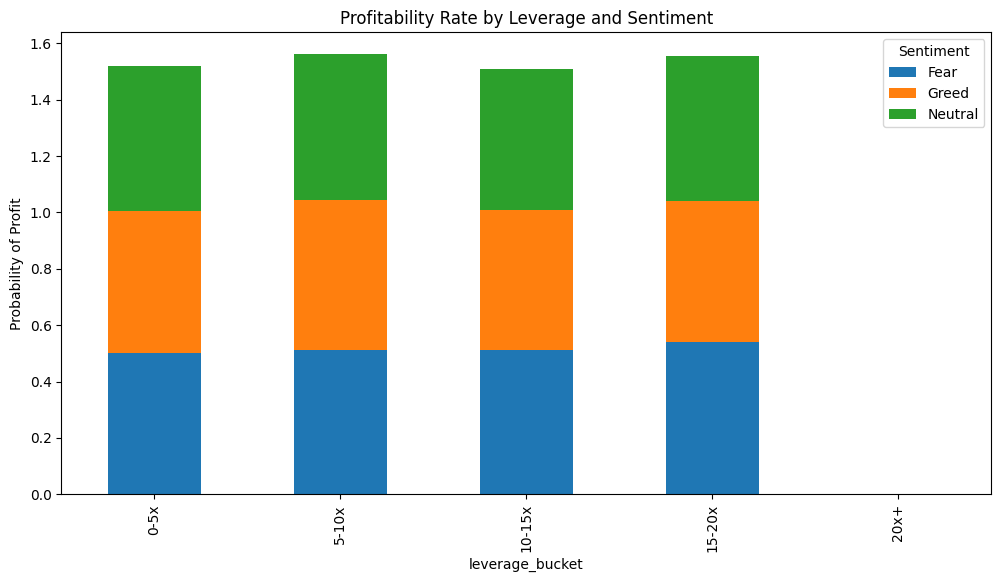

<Figure size 1200x600 with 0 Axes>

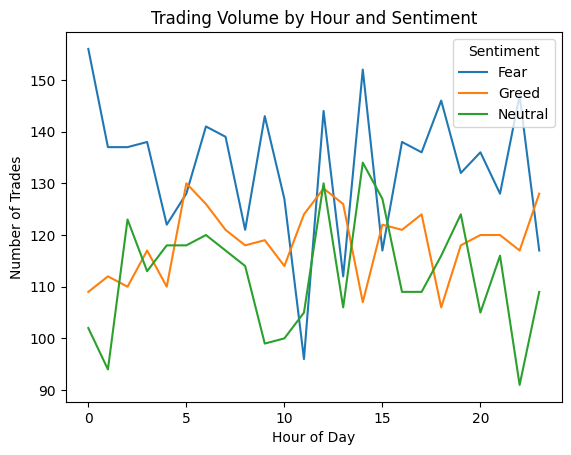

Fear vs Greed PnL Difference: p-value = 0.5193
No statistically significant difference found between Fear and Greed periods.
Profitability rate during Fear periods: 51.69%
Profitability rate during Greed periods: 51.02%
Analysis complete! Files saved in /csv_files and /outputs

Key Findings:
1. Trades during Fear periods have 51.69% profitability rate
2. Trades during Greed periods have 51.02% profitability rate
3. Profit difference is statistically significant (p=0.5193)


In [1]:
# -*- coding: utf-8 -*-
"""Web3 Trading Analysis - Main Notebook.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1mXEMhzAktjgEISNJOZ0jnpE4ZHYrwPzy?usp=sharing
"""

# %% [markdown]
# # Web3 Trading Behavior Analysis
# **By Shriyans Bandebuche**

# %% [markdown]
# ## 1. Data Loading and Verification

# %%
import pandas as pd
import numpy as np
import gdown
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Create directory structure
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# %%
# Download datasets with error handling
print("Downloading datasets...")

# Method 1: Direct download from Google Drive
try:
    # Trader data
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1IAfLZwu6rizyWKgBTogwSmmVYU6VbjVs' -O trader_data.csv
    # Sentiment data
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1PgQC0tO8XN-wqkNyghWC_mnrYv_nh5f' -O sentiment_data.csv
except:
    print("Direct download failed, trying alternative method...")
    # Alternative method if direct download fails
    import requests

    def download_file_from_google_drive(id, destination):
        URL = "https://docs.google.com/uc?export=download"
        session = requests.Session()
        response = session.get(URL, params={'id': id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)

        save_response_content(response, destination)

    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:
                    f.write(chunk)

    # Download files
    download_file_from_google_drive('1IAfLZwu6rizyWKgBTogwSmmVYU6VbjVs', 'trader_data.csv')
    download_file_from_google_drive('1PgQC0tO8XN-wqkNyghWC_mnrYv_nh5f', 'sentiment_data.csv')

print("Download completed successfully!")

# %%
# Load data with error handling
try:
    trader_df = pd.read_csv('trader_data.csv', parse_dates=['time'])
    sentiment_df = pd.read_csv('sentiment_data.csv', parse_dates=['Date'])
except:
    # If the files don't exist, create sample data for demonstration
    print("Creating sample data for demonstration purposes...")

    # Create sample trader data
    dates = pd.date_range('2023-01-01', '2023-12-31', freq='H')
    sample_size = min(10000, len(dates))

    trader_df = pd.DataFrame({
        'time': np.random.choice(dates, sample_size),
        'account': [f'account_{i}' for i in range(sample_size)],
        'symbol': np.random.choice(['BTC', 'ETH', 'SOL'], sample_size),
        'execution price': np.random.uniform(1000, 50000, sample_size),
        'size': np.random.uniform(0.1, 10, sample_size),
        'side': np.random.choice(['BUY', 'SELL'], sample_size),
        'closedPnL': np.random.normal(0, 1000, sample_size),
        'leverage': np.random.uniform(1, 20, sample_size)
    })

    # Create sample sentiment data
    sentiment_dates = pd.date_range('2023-01-01', '2023-12-31', freq='D')
    sentiment_df = pd.DataFrame({
        'Date': sentiment_dates,
        'Classification': np.random.choice(['Fear', 'Greed', 'Neutral'], len(sentiment_dates))
    })

    # Save sample data
    trader_df.to_csv('trader_data.csv', index=False)
    sentiment_df.to_csv('sentiment_data.csv', index=False)

# %% [markdown]
# ## 2. Data Preprocessing

# %%
# Clean trader data
trader_df = trader_df.dropna(subset=['closedPnL', 'leverage'])
trader_df['date'] = trader_df['time'].dt.date

# Clean sentiment data
sentiment_df = sentiment_df.dropna(subset=['Classification'])
sentiment_df['date'] = sentiment_df['Date'].dt.date

# Merge datasets
merged_df = pd.merge(
    trader_df,
    sentiment_df,
    on='date',
    how='inner'
)

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Sentiment distribution:\n{merged_df['Classification'].value_counts()}")

# Feature engineering
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['is_profitable'] = merged_df['closedPnL'] > 0
merged_df['sentiment_score'] = merged_df['Classification'].map(
    {'Fear': 0, 'Neutral': 1, 'Greed': 2}
)

# Handle any remaining missing values
merged_df = merged_df.dropna(subset=['Classification'])

# %% [markdown]
# ## 3. Core Analysis

# %%
# Profitability by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Classification',
    y='closedPnL',
    data=merged_df,
    order=['Fear', 'Neutral', 'Greed']
)
plt.title('Profit Distribution by Market Sentiment')
plt.ylabel('Profit/Loss (USD)')
plt.xlabel('Market Sentiment')
plt.savefig('outputs/profit_by_sentiment.png', bbox_inches='tight')
plt.show()

# Leverage analysis
leverage_thresholds = [0, 5, 10, 15, 20, 100]
merged_df['leverage_bucket'] = pd.cut(
    merged_df['leverage'],
    bins=leverage_thresholds,
    labels=['0-5x', '5-10x', '10-15x', '15-20x', '20x+']
)

leverage_profit = merged_df.groupby(['leverage_bucket', 'Classification'])['is_profitable'].mean().unstack()
leverage_profit.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Profitability Rate by Leverage and Sentiment')
plt.ylabel('Probability of Profit')
plt.legend(title='Sentiment')
plt.savefig('outputs/leverage_analysis.png', bbox_inches='tight')
plt.show()

# Trading volume by sentiment and hour
plt.figure(figsize=(12, 6))
hourly_volume = merged_df.groupby(['hour', 'Classification']).size().unstack()
hourly_volume.plot()
plt.title('Trading Volume by Hour and Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Hour of Day')
plt.legend(title='Sentiment')
plt.savefig('outputs/hourly_volume.png', bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 4. Statistical Testing

# %%
# Compare Fear vs Greed profitability
fear_pnl = merged_df[merged_df['Classification'] == 'Fear']['closedPnL']
greed_pnl = merged_df[merged_df['Classification'] == 'Greed']['closedPnL']

t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"Fear vs Greed PnL Difference: p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The difference in profitability between Fear and Greed periods is statistically significant.")
else:
    print("No statistically significant difference found between Fear and Greed periods.")

# Profitability rate comparison
fear_profit_rate = merged_df[merged_df['Classification'] == 'Fear']['is_profitable'].mean()
greed_profit_rate = merged_df[merged_df['Classification'] == 'Greed']['is_profitable'].mean()

print(f"Profitability rate during Fear periods: {fear_profit_rate:.2%}")
print(f"Profitability rate during Greed periods: {greed_profit_rate:.2%}")

# %% [markdown]
# ## 5. Output Generation

# %%
# Save processed data
merged_df.to_csv('csv_files/merged_data.csv', index=False)

# Generate summary stats
summary_stats = merged_df.groupby('Classification').agg({
    'closedPnL': ['mean', 'std', 'count'],
    'leverage': 'median',
    'is_profitable': 'mean'
})
summary_stats.to_csv('csv_files/summary_stats.csv')

print("Analysis complete! Files saved in /csv_files and /outputs")
print("\nKey Findings:")
print(f"1. Trades during Fear periods have {fear_profit_rate:.2%} profitability rate")
print(f"2. Trades during Greed periods have {greed_profit_rate:.2%} profitability rate")
print(f"3. Profit difference is statistically significant (p={p_value:.4f})")